# Exploring NDT & Paris-Traceroute in Africa

This Jupyter notebook visualizes M-Lab test data in Africa. Using BigQuery, we select NDT or paris-traceroute data from clients in Africa. Then, using a world map from Natural Earth and the GeoDataFrame Python packages, we plot the African data using geolocation hints from the data.

This notebook may be downloaded from the GitHub repository for the [M-Lab website](https://github.com/m-lab/m-lab.github.io/raw/master/notebooks/exploring-african-internet.ipynb).

### Setup

To do this, we need to install and configure some local dependencies first.

* Install [Jupyter](http://jupyter.org/install)
* Install [gcloud SDK](https://cloud.google.com/sdk/downloads) 
* Setup gcloud SDK

```
# Authenticate your account.
gcloud auth login

# Set default project.
gcloud config set project measurement-lab
```

* Install [google-cloud-bigquery](https://pypi.org/project/google-cloud-bigquery/) package:
  
```
pip install --upgrade google-cloud-bigquery
```

* Install [GeoPandas](http://geopandas.org/install.html) and dependencies

```
pip install geopandas PySAL descartes
```

* Start Jupyter

```
jupyter-notebook
```
 
### References

* Matplotlib - https://matplotlib.org/contents.html
* Pandas - https://pandas.pydata.org/pandas-docs/stable/api.html 
* BigQuery - https://cloud.google.com/bigquery/docs/reference/standard-sql/functions-and-operators 
* GeoPandas - http://geopandas.org/index.html

In [1]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import collections
import urllib2
import json
from shapely import geometry

# Ignore warnings from various packages.
import warnings
warnings.filterwarnings("ignore")

# Set project explicitly in the environment to suppress some warnings.
os.environ["GOOGLE_CLOUD_PROJECT"] = "measurement-lab"

# Load M-Lab site metadata including site latitude & longitude.
mlab_sites_url = 'https://storage.googleapis.com/operator-mlab-oti/metadata/v0/current/mlab-site-stats.json'

# Load the Natural Earth country shapes file.
worldmap_url = 'https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_50m_admin_0_countries.geojson'

# Short list of metros in Africa, for convenience.
african_metros = ['tun', 'jnb', 'cpt', 'mpm', 'tnr', 'los', 'nbo', 'acc']

# Number of colors to use when coloring maps.
colors = 10

# Default figure size. W x H.
figsize = (16, 10)

In [2]:
# Depends on: pip install --upgrade google-cloud-bigquery
from google.cloud import bigquery

def run_query(query, project='measurement-lab'):
    client = bigquery.Client(project=project)
    job = client.query(query)

    results = collections.defaultdict(list)
    for row in job.result(timeout=600):
        for key in row.keys():
            results[key].append(row.get(key))

    return pd.DataFrame(results)

In [3]:
# Load shape data.
globe_raw = gpd.read_file(worldmap_url)

# Select the global information (except Antarctica).
globe = globe_raw[['iso_a2', 'continent', 'geometry']].to_crs('+proj=longlat')
globe = globe[globe.continent != 'Antarctica']
# Add a new column with a default value of zero to show countries without data.
globe['default'] = 0

# Select only Africa.
africa = globe[globe.continent == 'Africa'].copy()
africa['default'] = 0
africa.sample(5)

,iso_a2,continent,geometry,default
79,GH,Africa,"POLYGON ((-0.068603515625 11.115625, -0.004736...",0
148,MZ,Africa,POLYGON ((32.88613281250002 -26.84931640625001...,0
154,NA,Africa,"POLYGON ((23.38066406250002 -17.640625, 23.594...",0
212,TG,Africa,POLYGON ((0.9004882812500061 10.99326171874999...,0
223,UG,Africa,POLYGON ((33.90322265625002 -1.002050781250006...,0


# NDT in Africa

How many NDT tests are clients in Africa running to M-Lab servers?

By default, the [M-Lab naming service](https://mlab-ns.appspot.com) directs clients to the geographically closest M-Lab server. The idea is to use geographic proximity as a proxy for network proximity. So, we expect to see more tests near M-Lab servers.

For a given day, the query below counts all tests from clients in Africa. At the same time we calculate the average download rate per country for all clients.

In [4]:
rates_df = run_query("""
SELECT
  connection_spec.client_geolocation.country_name as country_name,
  connection_spec.client_geolocation.country_code as country_code,
  COUNT(*) as count,
  AVG(8 * (web100_log_entry.snap.HCThruOctetsAcked /
      (web100_log_entry.snap.SndLimTimeRwin +
       web100_log_entry.snap.SndLimTimeCwnd +
       web100_log_entry.snap.SndLimTimeSnd))) AS download_Mbps
       
FROM
  `measurement-lab.ndt.base`
WHERE
      TIMESTAMP_TRUNC(log_time, DAY) = TIMESTAMP("2018-11-16")
  AND connection_spec.client_geolocation.continent_code = "AF"

  AND connection_spec.data_direction = 1
  AND web100_log_entry.snap.HCThruOctetsAcked >= 8192
  AND (web100_log_entry.snap.SndLimTimeRwin +
    web100_log_entry.snap.SndLimTimeCwnd +
    web100_log_entry.snap.SndLimTimeSnd) >= 9000000
  AND (web100_log_entry.snap.SndLimTimeRwin +
    web100_log_entry.snap.SndLimTimeCwnd +
    web100_log_entry.snap.SndLimTimeSnd) < 600000000
  AND web100_log_entry.snap.CongSignals > 0
  AND (web100_log_entry.snap.State = 1 OR
    (web100_log_entry.snap.State >= 5 AND
    web100_log_entry.snap.State <= 11))
  
GROUP BY
  country_code, country_name

HAVING
  count > 100

ORDER BY
 country_name, country_code, count desc
""")

In [5]:
# Now `rates_df` contains all results from the BigQuery results in the form of a Pandas DataFrame.
rates_df.sample(5)

,count,country_code,country_name,download_Mbps
7,12824,ZA,South Africa,9.959014
4,162,MG,Madagascar,16.446735
3,1702,KE,Kenya,5.796839
2,251,GH,Ghana,1.686178
10,217,UG,Uganda,2.270746


In [6]:
# Merge the africa dataframe with the rates_df using the 2-letter country codes in both.
rates_merged = africa.merge(rates_df, left_on='iso_a2', right_on='country_code')
rates_merged.sample(5)

,iso_a2,continent,geometry,default,count,country_code,country_name,download_Mbps
4,MA,Africa,POLYGON ((-4.628320312499966 35.20639648437501...,0,3001,MA,Morocco,5.918805
7,TN,Africa,(POLYGON ((10.95761718750006 33.72207031250005...,0,1972,TN,Tunisia,4.785937
1,EG,Africa,"POLYGON ((34.19814453125002 31.322607421875, 3...",0,481,EG,Egypt,1.942897
8,TZ,Africa,"(POLYGON ((39.711328125 -7.977441406250024, 39...",0,120,TZ,Tanzania,1.249333
9,UG,Africa,POLYGON ((33.90322265625002 -1.002050781250006...,0,217,UG,Uganda,2.270746


### Test Counts

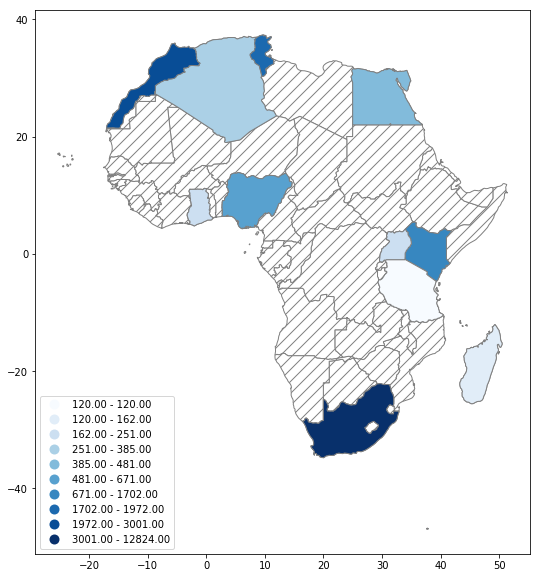

In [7]:
# First, plot the plain African map with hatch marks so all countries are represented.
ax0 = africa.plot(column='default', color='white', edgecolor='grey', figsize=figsize, hatch="//")
# Next, plot the merged rates dataframe on top of the base map. Only countries with data will be shown.
_ = rates_merged.plot(ax=ax0, column='count', cmap='Blues', scheme='Fisher_Jenks',
                      k=colors, legend=True, legend_kwds={"loc": 3}, edgecolor='grey')

### M-Lab Metro Locations

While the map above highlights countries where *users* are running NDT tests, it does not reveal the location of M-Lab servers used to run those tests.

To add M-Lab server locations to the map, next we will load the M-Lab site configuration for Africa.

In [8]:
# Download the M-Lab site configuration.
response = urllib2.urlopen(mlab_sites_url)
sites = json.loads(response.read())

# Collect all sites in Africa, creating a geometry.Point for each one.
all_map = {}
africa_map = {}
for row in sites:
    metro = row['site'][0:3]
    all_map[metro] = (metro, geometry.Point(row['longitude'], row['latitude']))
    if metro in african_metros:
        africa_map[metro] = all_map[metro]

# Convert the dict into a GeoDataFrame.
all_locations = gpd.GeoDataFrame(pd.DataFrame.from_dict(
    all_map, orient='index', columns=['metro', 'location']), geometry='location')
africa_locations = gpd.GeoDataFrame(pd.DataFrame.from_dict(
    africa_map, orient='index', columns=['metro', 'location']), geometry='location')

In [9]:
print africa_locations.keys()

Index([u'metro', u'location'], dtype='object')


### Test Counts With M-Lab Metro Locations

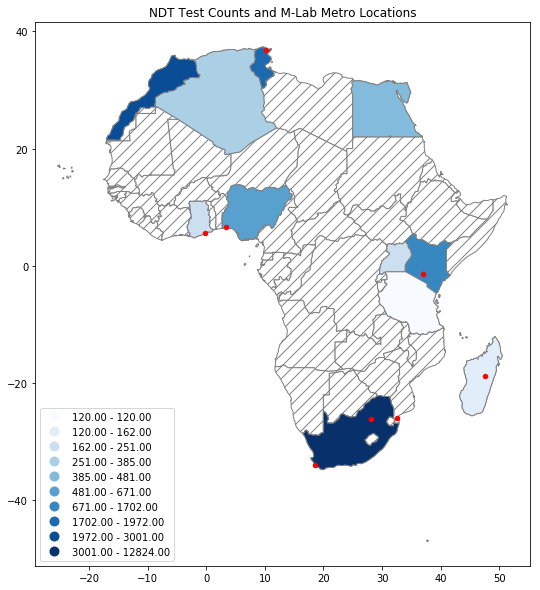

In [10]:
# Repeat the steps for plotting Africa test counts.
ax0 = africa.plot(column='default', color='white', edgecolor='grey', figsize=figsize, hatch="//")
ax1 = rates_merged.plot(ax=ax0, column='count', cmap='Blues', scheme='Fisher_Jenks',
                        k=colors, legend=True, legend_kwds={"loc": 3}, edgecolor='grey')
# Add the M-Lab metro locations.
africa_locations.plot(ax=ax1, color='red', markersize=20)
_ = ax1.set_title('NDT Test Counts and M-Lab Metro Locations')

### NDT Test Rates

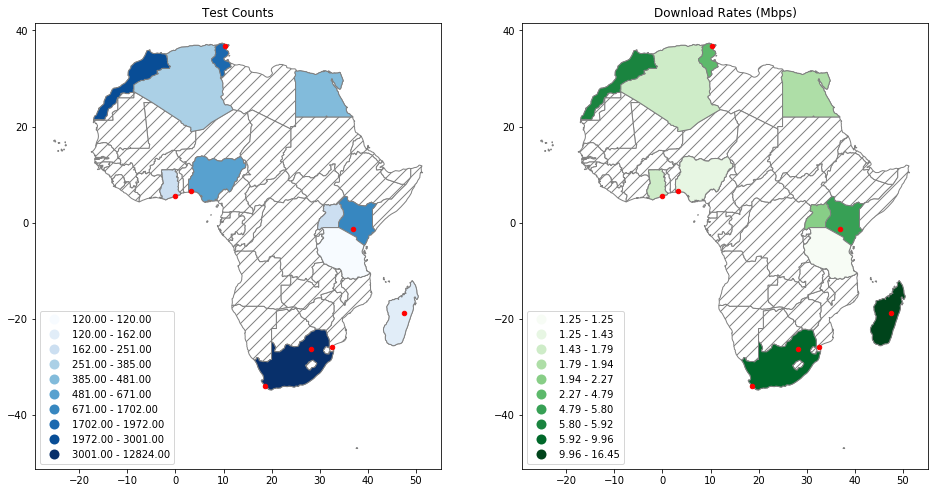

In [11]:
f, ax = plt.subplots(1, 2, figsize=figsize)

ax0 = africa.plot(ax=ax[0], column='default', color='white', edgecolor='grey', figsize=figsize, hatch="//")
ax1 = rates_merged.plot(ax=ax0, column='count', cmap='Blues', scheme='Fisher_Jenks',
                        k=colors, legend=True, legend_kwds={"loc": 3}, edgecolor='grey')
africa_locations.plot(ax=ax1, color='red', markersize=20)

ax0 = africa.plot(ax=ax[1], column='default', color='white', edgecolor='grey', figsize=figsize, hatch="//")
ax2 = rates_merged.plot(ax=ax0, column='download_Mbps', cmap='Greens', scheme='Fisher_Jenks',
                        k=colors, legend=True, legend_kwds={"loc": 3}, edgecolor='grey')
africa_locations.plot(ax=ax2, color='red', markersize=20)

_ = ax1.set_title('Test Counts')
_ = ax2.set_title('Download Rates (Mbps)')

# Paris-Traceroute in Africa

How are clients in Africa routed to M-Lab servers?

Every time a client machine contacts and M-Lab server, the server starts a paris-traceroute from the M-lab server to the client remote IP. Each paris-traceroute hop is annotated with geo-location metadata for the intermediate router IP address, including the country. 

For a given day, the query below counts the hops in all countries visited between all clients in Africa and the African M-Lab server they contacted. The query is limited to NDT tests (ports 3010 and 3001).

In [12]:
df_hops = {}
for metro in african_metros:
    print metro,
    df_hops[metro] = run_query("""
SELECT 
  paris_traceroute_hop.dest_geolocation.country_code as dest_country_code,
  COUNT(*) as hops
  
FROM
  `measurement-lab.traceroute.base`
  
WHERE
      TIMESTAMP_TRUNC(log_time, DAY) = TIMESTAMP("2018-11-16")
  AND REGEXP_CONTAINS(test_id, r"mlab[1-4].%s\d\d")
  AND connection_spec.client_geolocation.continent_code = "AF"
  AND (REGEXP_CONTAINS(test_id, ".*3010.paris.gz") OR REGEXP_CONTAINS(test_id, ".*3001.paris.gz"))

GROUP BY
  dest_country_code

HAVING
  hops > 50

ORDER BY
  hops desc
""" % metro)

tun jnb cpt mpm tnr los nbo acc


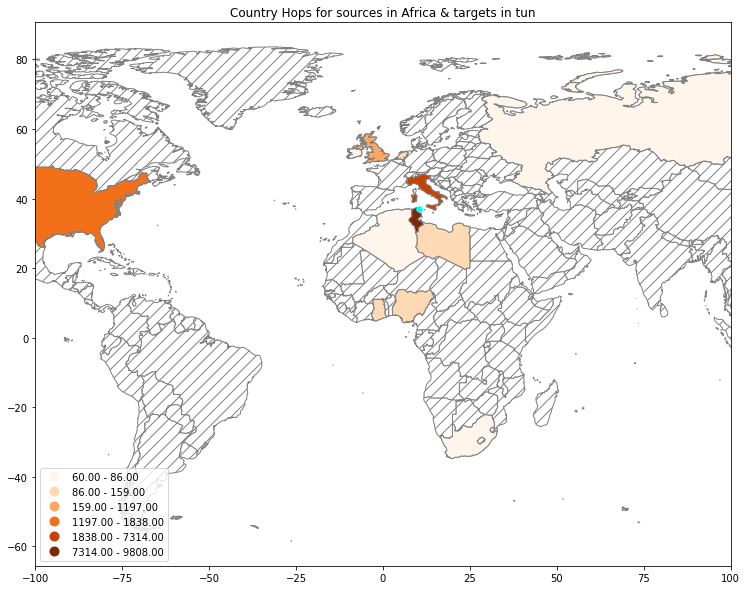

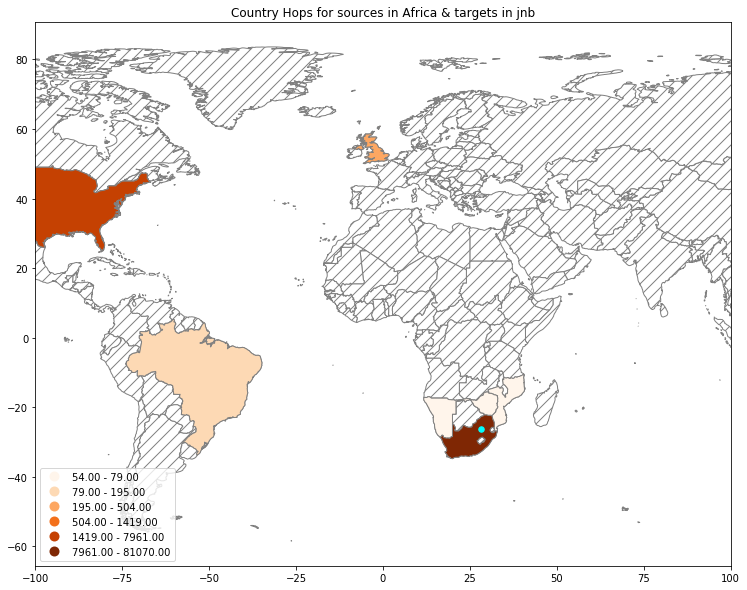

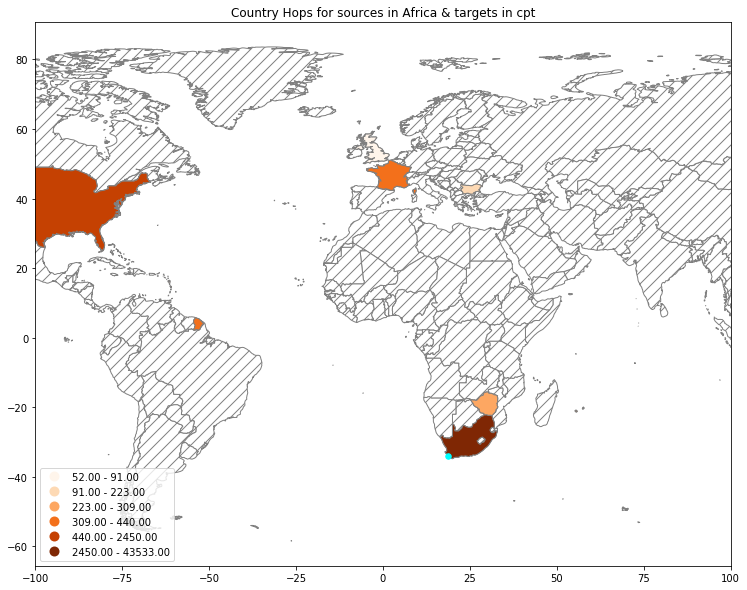

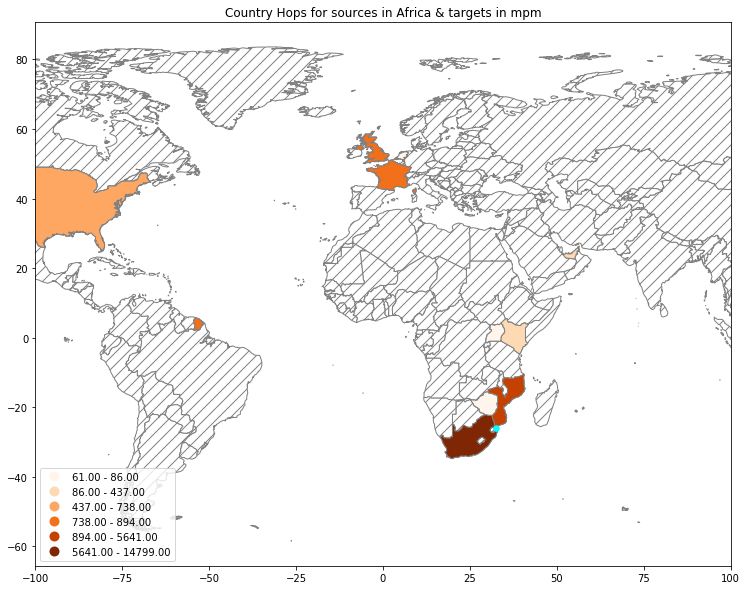

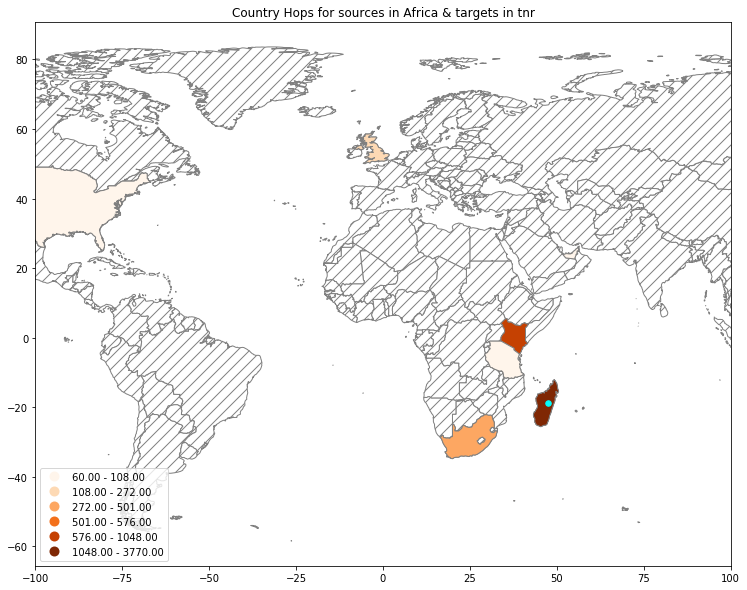

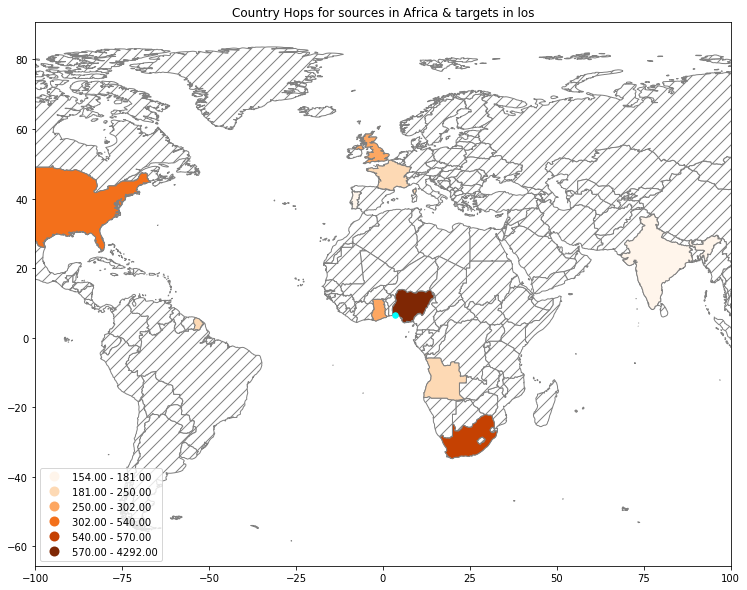

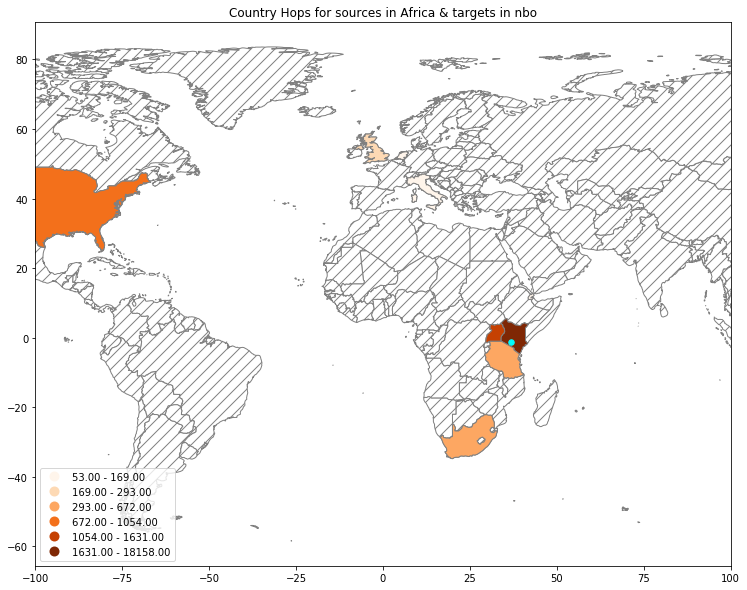

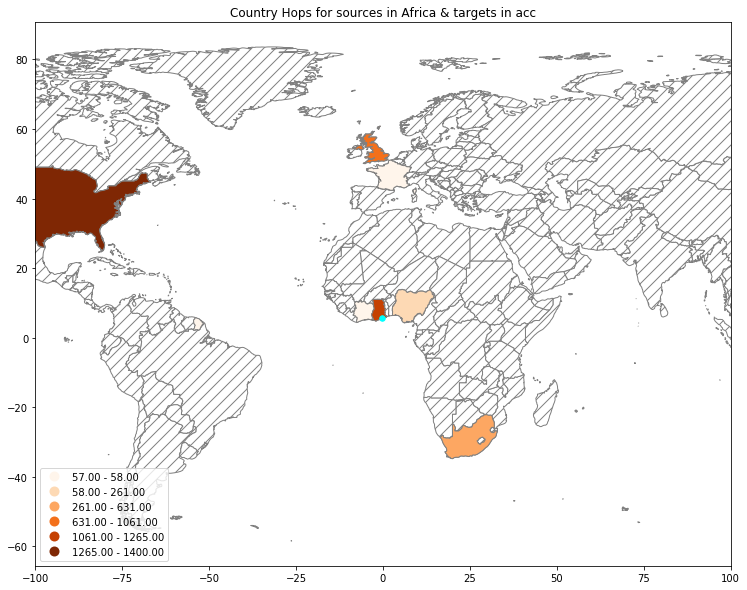

In [13]:
for metro in african_metros:
    if not len(df_hops[metro]):
        print "Skipping %s" % metro
        continue

    hops_merged = globe.merge(df_hops[metro], left_on='iso_a2', right_on='dest_country_code')

    ax1 = globe.plot(column='default', color='white', edgecolor='grey', figsize=figsize, hatch="//")
    ax2 = hops_merged.plot(ax=ax1, column='hops', cmap='Oranges', scheme='Fisher_Jenks',
                           k=6, legend=True, legend_kwds={"loc": 3}, edgecolor='grey')
    ax2.set_title('Country Hops for sources in Africa & targets in %s' % metro)
    africa_locations[africa_locations.metro == metro].plot(ax=ax2, color='cyan', markersize=30)
    ax2.set_xbound(-100, 100)